In [1]:
import plotting_heatmap_functions as pfn

In [21]:
import pandas as pd
import numpy as np
import bbi
from gffutils.helpers import asinterval
from gtfparse import read_gtf
import bioframe as bf
import matplotlib.pyplot as plt

In [3]:
# Importing day 1 depletion in ESCs DEGS

proj = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"

day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'

In [4]:
day1_res_df = pd.read_csv(proj+day1_sigRes)

In [5]:
day1_res_df

,Geneid,SYMBOL,log2FoldChange,padj,baseMean
0,ENSMUSG00000025128.7,Bhlhe22,-4.479336,4.277827e-03,7.794735
1,ENSMUSG00000051314.11,Ffar2,-3.910856,3.800000e-06,31.133503
2,ENSMUSG00000057182.15,Scn3a,-3.806326,5.010000e-18,144.877936
3,ENSMUSG00000047495.15,Dlgap2,-3.530066,4.213601e-03,9.073752
4,ENSMUSG00000034310.8,Tmem132d,-3.518345,3.690000e-10,63.300332
...,...,...,...,...,...
1614,ENSMUSG00000020826.9,Nos2,3.533920,7.987690e-04,9.674001
1615,ENSMUSG00000010080.15,Epn3,3.822547,2.040000e-08,18.206916
1616,ENSMUSG00000061353.11,Cxcl12,4.706828,1.610000e-05,9.619308
1617,ENSMUSG00000036744.13,Olfr701,5.052035,1.740000e-05,11.999807


Getting the TSSes 

Note: assuming that the RNA-seq alignment is still being done via STAR method from 

In [6]:
# Getting TSSEs
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")

/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/gtfparse/read_gtf.py:82: FutureWarning: The warn_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  chunk_iterator = pd.read_csv(
INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


In [7]:
# cleaning out less-well defined chromosome numbers
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('NT_'))]
tss_df = tss_df.loc[False==( tss_df['seqname'].str.contains('MT'))]

# paste 'chr' to all chromosome names
tss_df["seqname"] = tss_df["seqname"]

# rename column to chrom to match bedframe/bioframe format
tss_df = tss_df.rename(columns= {"seqname" : "chrom"})

# Removing pseudo chromosomes
before = len(tss_df)
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrGL'))]
tss_df = tss_df.loc[False==( tss_df['chrom'].str.contains('chrJH'))]
after = len(tss_df)

In [8]:
# drop duplicate TSSes
ts_intervals = tss_df[['gene_id','chrom', 'start', 'end']].drop_duplicates(['gene_id'])

In [9]:
day1_res_df

,Geneid,SYMBOL,log2FoldChange,padj,baseMean
0,ENSMUSG00000025128.7,Bhlhe22,-4.479336,4.277827e-03,7.794735
1,ENSMUSG00000051314.11,Ffar2,-3.910856,3.800000e-06,31.133503
2,ENSMUSG00000057182.15,Scn3a,-3.806326,5.010000e-18,144.877936
3,ENSMUSG00000047495.15,Dlgap2,-3.530066,4.213601e-03,9.073752
4,ENSMUSG00000034310.8,Tmem132d,-3.518345,3.690000e-10,63.300332
...,...,...,...,...,...
1614,ENSMUSG00000020826.9,Nos2,3.533920,7.987690e-04,9.674001
1615,ENSMUSG00000010080.15,Epn3,3.822547,2.040000e-08,18.206916
1616,ENSMUSG00000061353.11,Cxcl12,4.706828,1.610000e-05,9.619308
1617,ENSMUSG00000036744.13,Olfr701,5.052035,1.740000e-05,11.999807


In [10]:
ts_intervals

,gene_id,chrom,start,end
0,ENSMUSG00000102693.1,chr1,3073252,3073252
1,ENSMUSG00000064842.1,chr1,3102015,3102015
2,ENSMUSG00000051951.5,chr1,3216345,3216345
5,ENSMUSG00000102851.1,chr1,3252756,3252756
6,ENSMUSG00000103377.1,chr1,3368550,3368550
...,...,...,...,...
142440,ENSMUSG00000095523.1,JH584299.1,837363,837363
142441,ENSMUSG00000095475.1,JH584299.1,913084,913084
142442,ENSMUSG00000094855.1,JH584299.1,921941,921941
142443,ENSMUSG00000095019.1,JH584303.1,81606,81606


In [11]:
# drop gene from data field if there is no change associated
day1_res_df.dropna(subset=['log2FoldChange'], inplace=True)
day1_res_df = day1_res_df.merge(ts_intervals, left_on='Geneid', right_on='gene_id', how='left')

In [12]:
day1_res_df.head(3)

,Geneid,SYMBOL,log2FoldChange,padj,baseMean,gene_id,chrom,start,end
0,ENSMUSG00000025128.7,Bhlhe22,-4.479336,4.277827e-03,7.794735,ENSMUSG00000025128.7,chr3,18054173,18054173
1,ENSMUSG00000051314.11,Ffar2,-3.910856,3.800000e-06,31.133503,ENSMUSG00000051314.11,chr7,30823776,30823776
2,ENSMUSG00000057182.15,Scn3a,-3.806326,5.010000e-18,144.877936,ENSMUSG00000057182.15,chr2,65567493,65567493


In [13]:
# Checking if any of the significant genes will be lost due to loss of TSS annotation
print("Checking for 'lost' significant genes: ")
ix = np.where(day1_res_df['start'].isna() & (day1_res_df['padj'] < 0.05))
print("lost: ", str(day1_res_df.iloc[ix].shape[0]))

# If could not find a TSS, drop entire row
day1_res_df.dropna(subset=['start'], inplace=True)

Checking for 'lost' significant genes: 
lost:  0


In [14]:
def label_DE_status_deseq2(gene_row):
    
    cutoff_col = 'padj'
    pval_cutoff = 0.05
    de_value_col = 'log2FoldChange'
    
    if gene_row[cutoff_col] < pval_cutoff:
        if gene_row[de_value_col] < 0:
            return 'down'
        else:
            return 'up'
    return 'nonsig'

In [15]:
day1_res_df['DE_status'] = day1_res_df.apply(lambda row: label_DE_status_deseq2(row), axis=1)

Where is ChIP relative to dysregulated genes? 

Interesting proteins: For Rad21? For CTCF? For Nipbl? Polycomb proteins (RING1B, SUZ12)?

In [16]:
# Load Chip-Seq files 
chip_folder = "/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/"

ctcf_new = "CTCF_E14_RSC13new-22-37-60_average.bw"
rad21 = "RAD21_E14_RSC12new-21-36-59-74_average.bw"
nipbl = "NIPBL_E14_EA112-EA175_average.bw"
ring1b = "RING1B_E14_RSC24-39-62_average.bw"
promoter = "H3K27Ac_mESCs_EA92-EA94_average.bw"

In [17]:
chip_seq_condition_dict = {'CTCF' : chip_folder+ctcf_new, 'RAD21' : chip_folder+rad21,
                           'NiBL' : chip_folder+nipbl, 'RING1B' : chip_folder+ring1b,
                           'H3K27ac' : chip_folder+promoter}

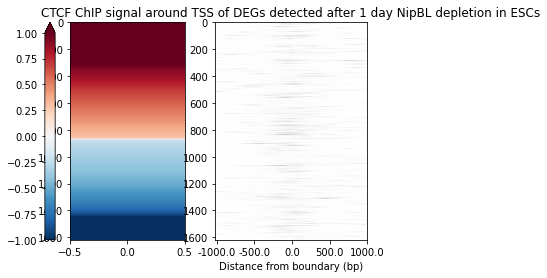

/home1/pokorny/transcription-modeling/plotting_heatmap_functions.py:38: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(cat_matrix, axis=0), color = color, label=category)


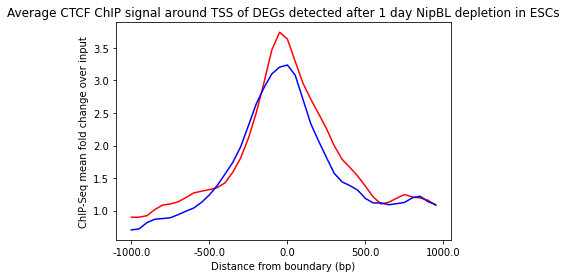

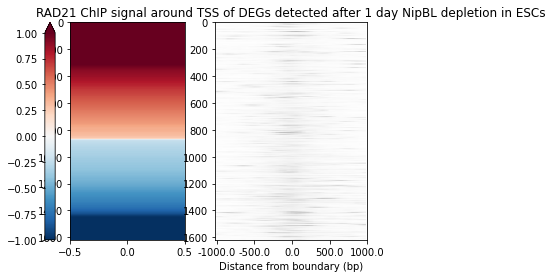

/home1/pokorny/transcription-modeling/plotting_heatmap_functions.py:38: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(cat_matrix, axis=0), color = color, label=category)


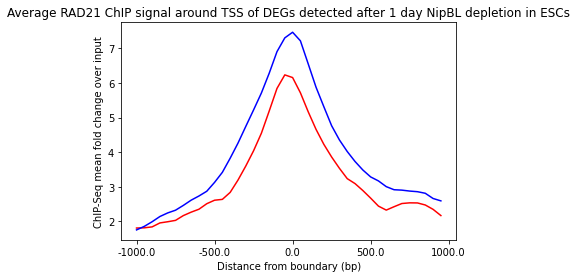

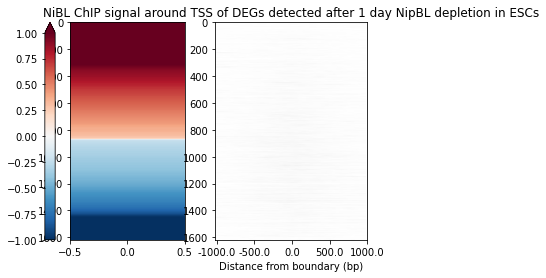

/home1/pokorny/transcription-modeling/plotting_heatmap_functions.py:38: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(cat_matrix, axis=0), color = color, label=category)


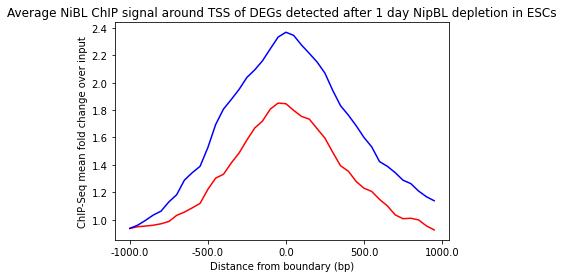

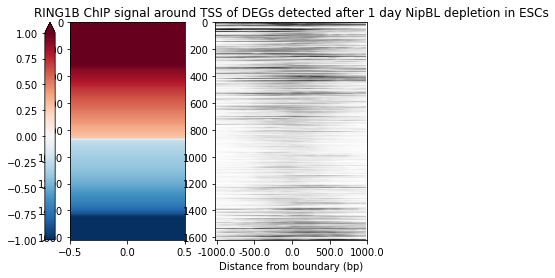

/home1/pokorny/transcription-modeling/plotting_heatmap_functions.py:38: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(cat_matrix, axis=0), color = color, label=category)


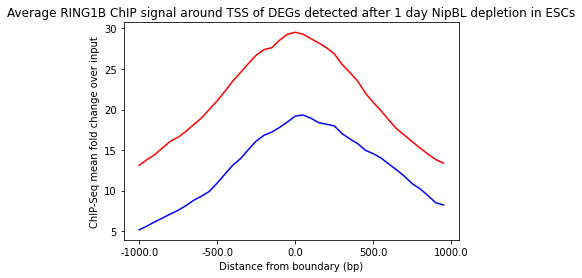

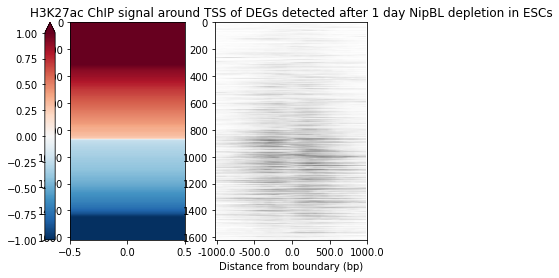

/home1/pokorny/transcription-modeling/plotting_heatmap_functions.py:38: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(cat_matrix, axis=0), color = color, label=category)


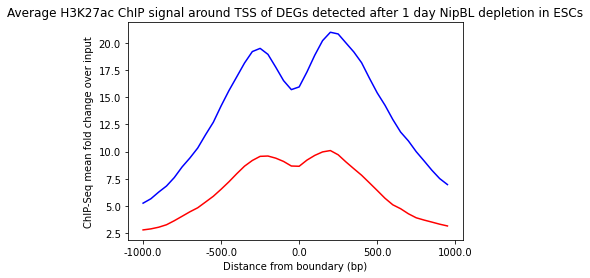

In [22]:
for cond, chip_file in chip_seq_condition_dict.items():
    
    matrix = pfn.generate_signal_matrix(chip_file, 
                                day1_res_df['chrom'], 
                                day1_res_df['start'], 
                                day1_res_df['end'], 
                                windowSize=1000, 
                                windowType='extend', 
                                nbins=40)
    
    
    
    pfn.plot_binned_signal_heatmap(day1_res_df, 
                           matrix, 
                           title="{} ChIP signal around TSS of DEGs detected after 1 day NipBL depletion in ESCs".format(cond),
                           sort_by_DE=True, 
                           agg_key='DE_status', 
                           agg_categories=['up', 'down'],
                           include_category_map=True,
                           color_categories=['r', 'b'])
    plt.show()
    
    pfn.plot_avg_signal(day1_res_df, 
                    matrix, 
                    title="Average {} ChIP signal around TSS of DEGs detected after 1 day NipBL depletion in ESCs".format(cond))
    
    plt.show()


### Extending window to +/- 100kbp

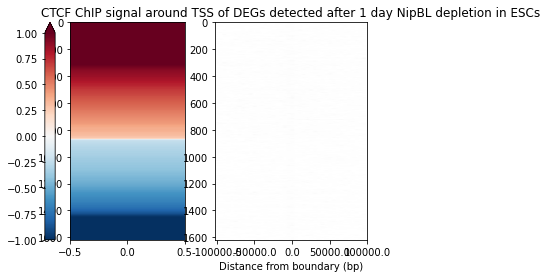

/home1/pokorny/transcription-modeling/plotting_heatmap_functions.py:38: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(cat_matrix, axis=0), color = color, label=category)


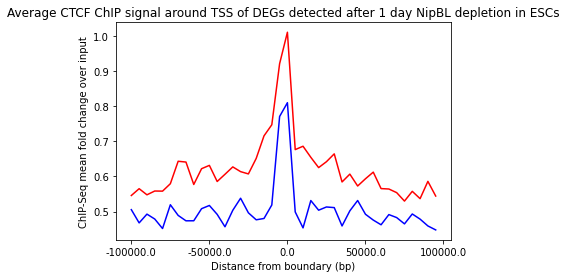

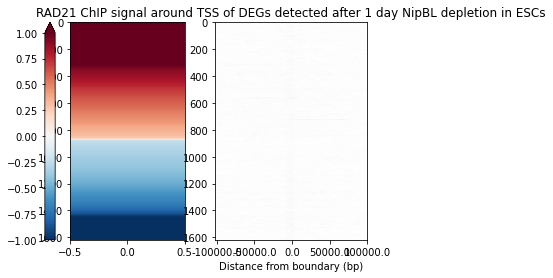

/home1/pokorny/transcription-modeling/plotting_heatmap_functions.py:38: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(cat_matrix, axis=0), color = color, label=category)


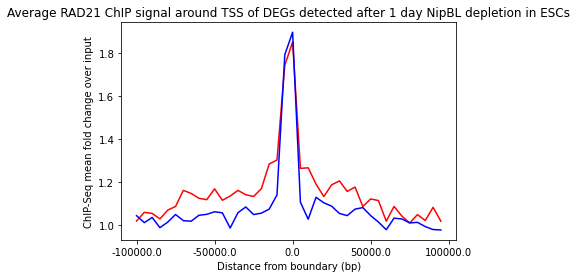

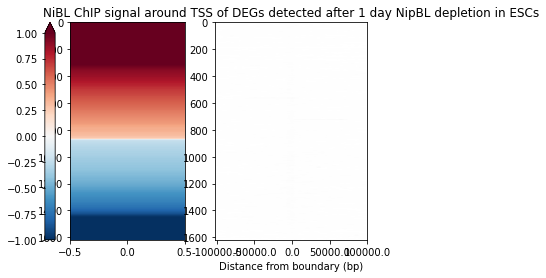

/home1/pokorny/transcription-modeling/plotting_heatmap_functions.py:38: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(cat_matrix, axis=0), color = color, label=category)


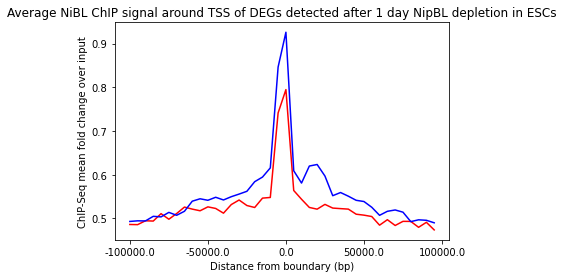

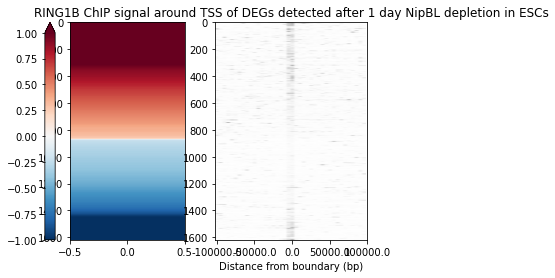

/home1/pokorny/transcription-modeling/plotting_heatmap_functions.py:38: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(cat_matrix, axis=0), color = color, label=category)


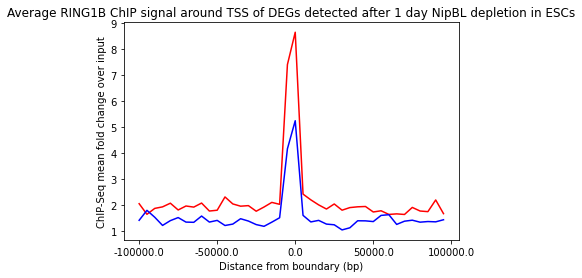

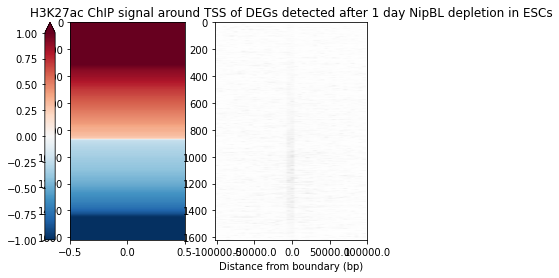

/home1/pokorny/transcription-modeling/plotting_heatmap_functions.py:38: RuntimeWarning: Mean of empty slice
  ax.plot(np.nanmean(cat_matrix, axis=0), color = color, label=category)


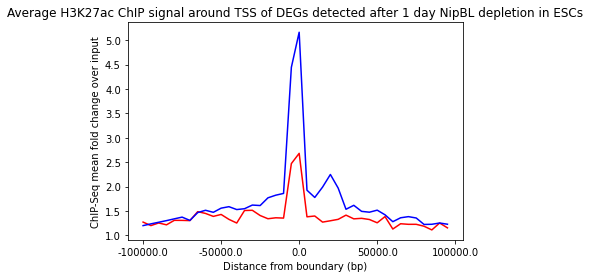

In [25]:
for cond, chip_file in chip_seq_condition_dict.items():
    
    matrix = pfn.generate_signal_matrix(chip_file, 
                                day1_res_df['chrom'], 
                                day1_res_df['start'], 
                                day1_res_df['end'], 
                                windowSize=100000, 
                                windowType='extend', 
                                nbins=40)
    
    
    
    pfn.plot_binned_signal_heatmap(day1_res_df, 
                           matrix, 
                           title="{} ChIP signal around TSS of DEGs detected after 1 day NipBL depletion in ESCs".format(cond),
                           sort_by_DE=True, 
                           agg_key='DE_status', 
                           agg_categories=['up', 'down'],
                           include_category_map=True,
                           color_categories=['r', 'b'],
                            windowSize=100000,
                              nbins=40)
    plt.show()
    
    pfn.plot_avg_signal(day1_res_df, 
                    matrix, 
                    title="Average {} ChIP signal around TSS of DEGs detected after 1 day NipBL depletion in ESCs".format(cond),
                   windowSize=100000,
                   nbins=40)
    
    plt.show()

### Window +/- 10kbp

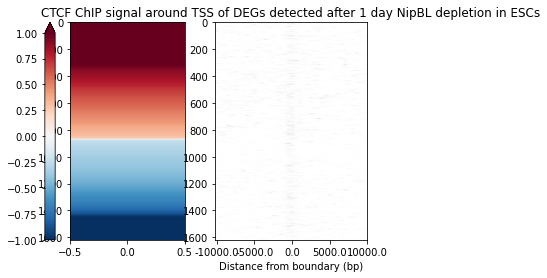

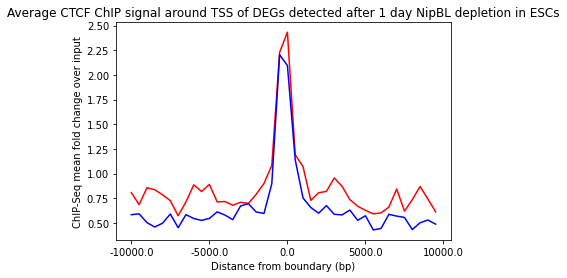

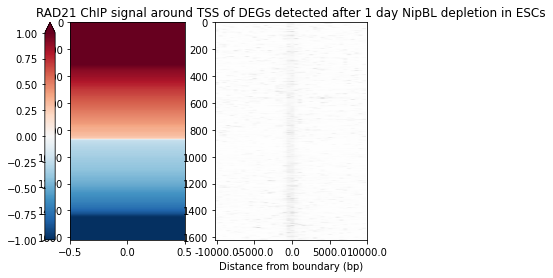

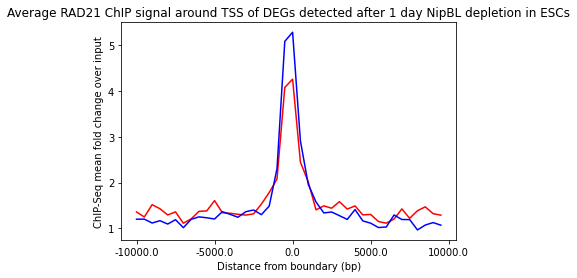

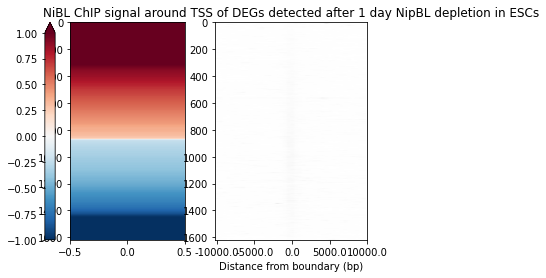

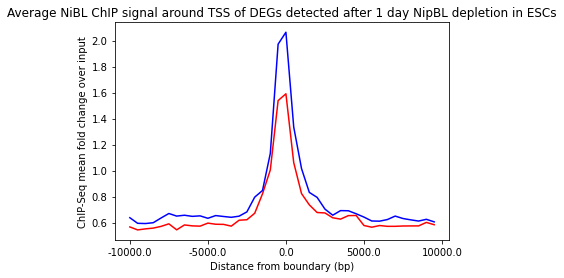

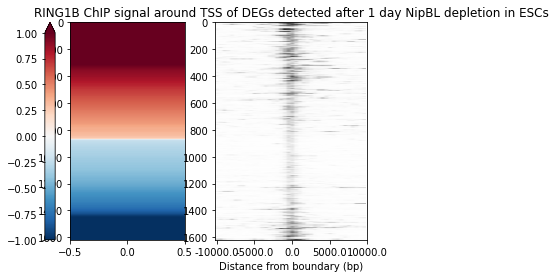

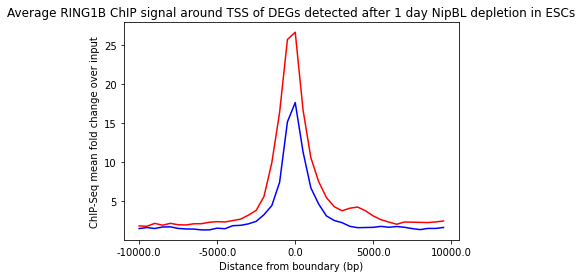

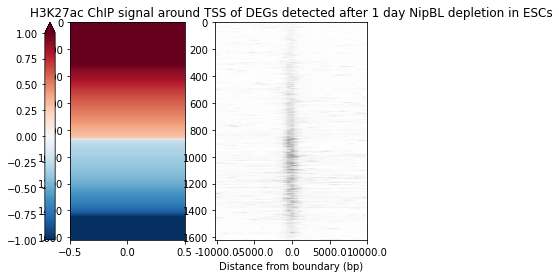

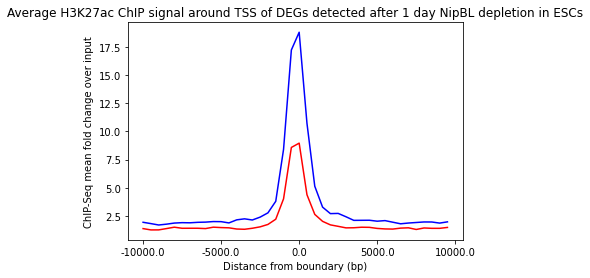

In [27]:
window = 10000
for cond, chip_file in chip_seq_condition_dict.items():
    
    matrix = pfn.generate_signal_matrix(chip_file, 
                                day1_res_df['chrom'], 
                                day1_res_df['start'], 
                                day1_res_df['end'], 
                                windowSize=window, 
                                windowType='extend', 
                                nbins=40)
    
    
    
    pfn.plot_binned_signal_heatmap(day1_res_df, 
                           matrix, 
                           title="{} ChIP signal around TSS of DEGs detected after 1 day NipBL depletion in ESCs".format(cond),
                           sort_by_DE=True, 
                           agg_key='DE_status', 
                           agg_categories=['up', 'down'],
                           include_category_map=True,
                           color_categories=['r', 'b'],
                            windowSize=window,
                              nbins=40)
    plt.show()
    
    pfn.plot_avg_signal(day1_res_df, 
                    matrix, 
                    title="Average {} ChIP signal around TSS of DEGs detected after 1 day NipBL depletion in ESCs".format(cond),
                    agg_categories=['up', 'down'],
                   windowSize=window,
                   nbins=40)
    
    plt.show()